## Portfolio Optimization Using the Efficient Frontier

Portfolio optimization focuses on constructing an optimal allocation of assets to maximize returns while minimizing risk. In this script, Mean-Variance Optimization (MVO) using historical stock data to build an efficient portfolio is implemented. 

5 stocks are used in this script (which can be expanded into more stocks) to ensure diversification.
- Apple Inc. (AAPL) – Technology
- JPMorganChase (JPM) – Financials
- ExxonMobil (XOM) – Energy
- Procter & Gamble (PG) – Consumer Goods
- NVIDIA (NVDA) – Semiconductors

The key objectives of this script include:
1. Data Collection & Processing – Fetching historical stock price data and computing daily returns.
2. Risk-Return Analysis – Calculating mean returns and the covariance matrix.
3. Portfolio Optimization – Using Scipy's optimization tools to compute efficient portfolio allocations for different risk-return trade-offs.
4. Efficient Frontier Visualization – Plotting the efficient frontier to illustrate the optimal portfolios for varying levels of risk.

This provides a weighted portfolio striking a balance between returns and risk exposure. It also sets the foundation for further enhancements such as Monte-Carlo simulations, Sharpe ratio maximization and factor-based portfolio construction.

### Data collection

yfinance will be used to get data as it is free. The code gets the closing price for 5 stocks over 4 years.

In [25]:
import yfinance as yf
import pandas as pd

# choosing 5 stocks across different sectors
tickers = ['AAPL', 'JPM', 'XOM', 'PG', 'NVDA']

data = yf.download(tickers, start="2020-01-01", end="2024-01-01")['Close']
data = data.dropna()  # Remove any rows with missing data

print(data.head())

[*********************100%***********************]  5 of 5 completed

Ticker           AAPL         JPM      NVDA          PG        XOM
Date                                                              
2020-01-02  72.716057  121.477242  5.972710  108.419876  55.137985
2020-01-03  72.009125  119.874168  5.877112  107.690704  54.694695
2020-01-06  72.582916  119.778839  5.901758  107.840034  55.114655
2020-01-07  72.241554  117.742523  5.973209  107.172371  54.663593
2020-01-08  73.403633  118.661026  5.984412  107.629196  53.839241


### Data preparation

Raw prices do not give a good idea of performance, returns measure percentage change making stock prices comparable.
Mean returns gives the average return of each stock. 

Covariance matrix shows how stocks move more relative to each other. If 2 stocks are highly correlated, they wont reduce risk when combined. And if they are negatively correlated, they help hedge against each other

In [26]:
# pct change is the fractional change from the previous row
returns = data.pct_change().dropna() 

# calculating the mean returns and covariance matrices
mean_returns = returns.mean()
cov_matrix = returns.cov()

print(mean_returns)
print(cov_matrix)

Ticker
AAPL    0.001187
JPM     0.000541
NVDA    0.002685
PG      0.000367
XOM     0.000825
dtype: float64
Ticker      AAPL       JPM      NVDA        PG       XOM
Ticker                                                  
AAPL    0.000447  0.000210  0.000483  0.000142  0.000154
JPM     0.000210  0.000470  0.000272  0.000126  0.000302
NVDA    0.000483  0.000272  0.001167  0.000147  0.000177
PG      0.000142  0.000126  0.000147  0.000195  0.000081
XOM     0.000154  0.000302  0.000177  0.000081  0.000550


### Defining portfolio functions

Port return calculates the weighted sum of expected returns for each stock. Higher weights on high-return stocks increase portfolio return

Port variance measures risk. This formula used: $V = w^TCw$, where V is variance, w is the weights vector and C is the covariance matrix

Lower variance would imply a less risky portfolio

In the mean-variance optimization (Markowitz Model), the portfolio that has the least risk for a given return is found out.

In [27]:
import numpy as np

def portfolio_performance(weights, mean_returns, cov_matrix):
    port_return = np.sum(mean_returns * weights)
    port_variance = np.dot(weights.T, np.dot(cov_matrix, weights))
    return port_return, port_variance

def min_variance(weights, cov_matrix):
    return np.dot(weights.T, np.dot(cov_matrix, weights))

### Optimization

Optimal stock weights that give the lowest risk for a given target return is obtained here.

The starting point is considered to be an equal weighted portfolio where each of the stocks gets an equal weight (20% in this case) to adjust the weights

Constraints ensure that the total investment sums up to 1 ensuring that all the money is allocated; and that that target return is matched. This ensures that an ultra low risk portfolio is not obtained with too low a return.

The bounds ensure that negative weights are not assgined (no short selling). It also prevents leverage with weights being greater than 1. 

#### Scipy minimize()
This function iteratively adjusts the stock weights. it minimizes the variance of the portfolio (given by min_variance funtion)

SLSQP stands for Sequential Least Squares Programming and is used as it works well with problems with constraints and supports bounds.


In [28]:
from scipy.optimize import minimize

def optimize_portfolio(target_return, mean_returns, cov_matrix):
    num_assets = len(mean_returns)
    args = (cov_matrix,)
    # initial guess: equally weighted portfolio
    init_guess = num_assets * [1. / num_assets,]
    # constraints: sum of weights equals 1 and portfolio return equals target_return
    constraints = (
        {'type': 'eq', 'fun': lambda x: np.sum(x) - 1},
        {'type': 'eq', 'fun': lambda x: np.sum(mean_returns * x) - target_return},
    )
    bounds = tuple((0, 1) for asset in range(num_assets))
    result = minimize(min_variance, init_guess, args=args,
                      method='SLSQP', bounds=bounds, constraints=constraints)
    return result


### Efficient frontier

The efficient frontier represents a set of optimal portfolios that offer the highest return for a given level of risk, or the lowest risk for a given level of return. The goal is to plot the efficient frontier by finding the minimum variance portfolio for different target returns. 

A range of returns is generated (eg 5%, 20%, etc)
Then optimize_portfolio() is called to get the lower risk portfolio for that return.

In [29]:
target_returns = np.linspace(mean_returns.min(), mean_returns.max(), 50)
portfolio_returns = []
portfolio_variances = []
portfolio_weights = []

for target in target_returns:
    opt = optimize_portfolio(target, mean_returns, cov_matrix)
    if opt.success:
        ret, var = portfolio_performance(opt.x, mean_returns, cov_matrix)
        portfolio_returns.append(ret)
        portfolio_variances.append(np.sqrt(var))
        portfolio_weights.append(opt.x)
    else:
        print("Optimization failed for target return: ", target)

### Visualizing results

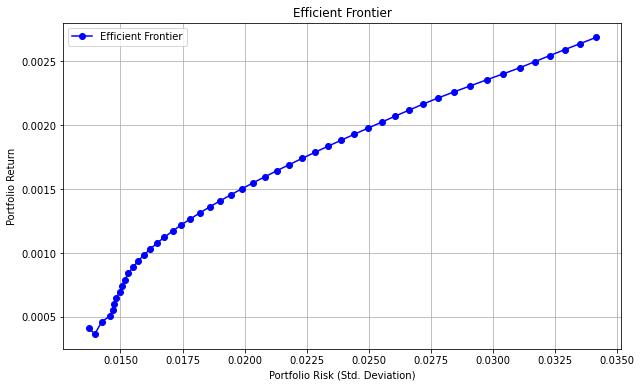

Sample portfolio weights along the Efficient Frontier:

Target Return: 0.0004 | Weights: [0.00000000e+00 2.01227923e-16 2.86030236e-17 1.00000000e+00
 0.00000000e+00]
Target Return: 0.0009 | Weights: [0.19643319 0.23127815 0.11535865 0.24092964 0.21600036]
Target Return: 0.0015 | Weights: [0.20730363 0.13563262 0.37322969 0.11660478 0.16722928]
Target Return: 0.0021 | Weights: [0.2159176  0.03601016 0.63283384 0.         0.1152384 ]
Target Return: 0.0027 | Weights: [1.72945680e-09 2.49800181e-16 9.99999998e-01 8.32667268e-17
 0.00000000e+00]


In [32]:
import matplotlib.pyplot as plt

sorted_indices = np.argsort(portfolio_variances)
sorted_risks = np.array(portfolio_variances)[sorted_indices]
sorted_returns = np.array(portfolio_returns)[sorted_indices]

plt.figure(figsize=(10, 6))
plt.plot(sorted_risks, sorted_returns, linestyle='-', marker='o', color='b', label="Efficient Frontier")
plt.xlabel('Portfolio Risk (Std. Deviation)')
plt.ylabel('Portfolio Return')
plt.title('Efficient Frontier')
plt.legend()
plt.grid(True)
plt.show()

# Convert to NumPy array for easier analysis
portfolio_weights = np.array(portfolio_weights)

# Print weights for 5 sample points on the frontier
print("Sample portfolio weights along the Efficient Frontier:\n")
for i in np.linspace(0, len(portfolio_weights) - 1, 5, dtype=int):
    print(f"Target Return: {target_returns[i]:.4f} | Weights: {portfolio_weights[i]}")

#### Minimum Variance Portfolio (targeted daily return = 0.0004)

100% allocation for P&G which implies PG to be the most stable stock minimizing risk

#### Diversified Portfolio (targeted daily return = 0.0009)

Well balanced allocations: AAPL - 19.64%, JPM - 23.13%, XOM: 11.54%, PG: 24.09%, NVDA: 21.60%

#### Medium Risk Portfolio (targeted daily return = 0.0015)

Higher allocation to XOM and lesser weight in JPM and PG. There is a slight shift to higher risk stocks

#### High Risk Portfolio (targeted daily return = 0.0021)

XOM dominated with 63.28%. JPM drops further and PG is removed completely. This implies an even higher weightage on higher risk stocks

#### Minimum Variance Portfolio (targeted daily return = 0.0027)

100% allocation for XOM, which has the highest risk among all the other portfolios